font + packages

In [1]:
# Hide warnings
# import warnings
# warnings.filterwarnings('ignore')

# Or using IPython magic command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython import get_ipython
from IPython.display import Javascript

def increase_font(event=None):
    display(Javascript('''
    for (rule of document.styleSheets[0].cssRules){
        if (rule.selectorText=='body') {
            rule.style.fontSize = '24px'
            break
        }
    }
    '''))

get_ipython().events.register('pre_run_cell', increase_font)

# Ensure all necessary imports are resolved
import pybaseball as bb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from scipy.ndimage import gaussian_filter
import catboost as cb
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

In [ ]:
df = bb.statcast(start_dt='2024-03-01', end_dt='2024-12-01')
df = df.reset_index(drop=True)
df.shape

In [3]:
swing_events = [
    'foul', 'foul_tip', 'swinging_strike', 'swinging_strike_blocked', 'hit_into_play'
]

contact_events = [
    'foul', 'foul_tip', 'hit_into_play'
]
df['contact'] = 0
df['swing'] = 0
df.loc[df['description'].isin(swing_events), 'swing'] = 1
df.loc[df['description'].isin(contact_events), 'contact'] = 1
df['bat_speed'] = df['bat_speed'].astype(float)
df['swing_length'] = df['swing_length'].astype(float)


<IPython.core.display.Javascript object>

In [4]:
df['swing'].describe()

<IPython.core.display.Javascript object>

count    248653.000000
mean          0.479242
std           0.499570
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: swing, dtype: float64

In [5]:
df['bat_speed'].count()/df.shape[0]

<IPython.core.display.Javascript object>

0.34004817959163974

In [6]:
df.columns.values

<IPython.core.display.Javascript object>

array(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4',
       'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
       'release_pos_y', 'estima

In [7]:
df.loc[(df['swing']==1) & (df['bat_speed'].isna()), 'game_date'].value_counts().head(50)

<IPython.core.display.Javascript object>

game_date
2024-03-30    2298
2024-03-23    2090
2024-03-31    2062
2024-03-16    2037
2024-04-01    1987
2024-03-17    1985
2024-03-28    1793
2024-04-02    1681
2024-03-24    1601
2024-03-21    1563
2024-03-19    1485
2024-03-20    1448
2024-03-22    1429
2024-03-25    1413
2024-03-29    1355
2024-03-18    1331
2024-03-26    1240
2024-03-15    1151
2024-04-27     309
2024-04-20     252
2024-04-28     241
2024-04-06     171
2024-05-20     152
2024-04-08     149
2024-04-03     138
2024-04-12     131
2024-04-16     126
2024-04-09     125
2024-04-14     124
2024-04-30     113
2024-04-13     112
2024-04-22     109
2024-05-03     108
2024-05-07     106
2024-05-10     104
2024-04-17     101
2024-05-01     100
2024-04-15      99
2024-05-14      98
2024-05-21      97
2024-04-23      97
2024-04-24      96
2024-05-04      95
2024-05-13      94
2024-04-05      92
2024-04-19      91
2024-05-11      90
2024-05-08      88
2024-05-17      88
2024-04-26      87
Name: count, dtype: int64

In [8]:
df.columns.values

<IPython.core.display.Javascript object>

array(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4',
       'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
       'release_pos_y', 'estima

In [9]:
df = df.rename(columns={'player_name':'pitcher_name'})
batter_bio = bb.playerid_reverse_lookup(df['batter'].unique().tolist())
batter_bio['batter_name'] = batter_bio['name_last'].str.capitalize().add(', ').add(batter_bio['name_first'].str.capitalize())
batter_bio = batter_bio.rename(columns={'key_mlbam':'batter'})
df = df.merge(batter_bio.loc[:, ['batter', 'batter_name']], how='left')


<IPython.core.display.Javascript object>

Gathering player lookup table. This may take a moment.


swing speed kde plots

https://twitter.com/blandalytics/status/1790821842565157326/photo/1  

In [10]:
bb.playerid_lookup(last='arraez')

<IPython.core.display.Javascript object>

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last


<IPython.core.display.Javascript object>

<Axes: xlabel='bat_speed', ylabel='Density'>

<Axes: xlabel='bat_speed', ylabel='Density'>

Text(68.47226449350362, 0.01, 'Avg Speed: 68')

(20.0, 95.0)

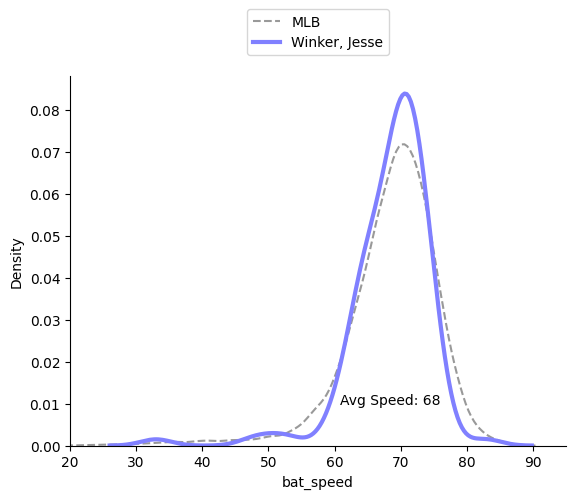

In [11]:
bid = 608385
df_plt = df.loc[(df['batter']==bid) & (df['strikes']==2)].copy()
name_str = df_plt['batter_name'].unique()[0]
speed = int(round(df_plt['bat_speed'].mean(),0))
sns.kdeplot(df.loc[(df['strikes']==2),'bat_speed'], label='MLB', ls='--',color=(0.6,0.6,0.6))
sns.kdeplot(df_plt['bat_speed'], label=name_str, lw=3, color=(0.5,0.5,1))
plt.text(df_plt['bat_speed'].mean(), 0.01, f"Avg Speed: {speed}", ha='center')
plt.xlim(20,95)
plt.legend(loc=9, bbox_to_anchor=(0.5,1.2))
sns.despine()
plt.show()

swing speed with/without 2 strikes

https://twitter.com/sunshinevvn/status/1789880500506472695/photo/1

In [12]:
_df_plt = df.loc[df['strikes']==2, ['batter', 'batter_name', 'bat_speed']].groupby(['batter', 'batter_name'], as_index=False).mean()
_df_plt = _df_plt.rename(columns={'bat_speed':'bat_speed_2s'})
df_plt = df.loc[df['strikes']<2, ['batter', 'batter_name', 'bat_speed']].groupby(['batter', 'batter_name'], as_index=False).mean()
df_plt = df_plt.merge(_df_plt)
df_plt['bat_speed_diff'] = df_plt['bat_speed_2s'].sub(df_plt['bat_speed'])
df_plt['coward'] = 1
df_plt.loc[df_plt['bat_speed_diff']>0, 'coward'] = 0
df_plt.shape

<IPython.core.display.Javascript object>

(641, 6)

<IPython.core.display.Javascript object>

(60.0, 85.0)

(60.0, 85.0)

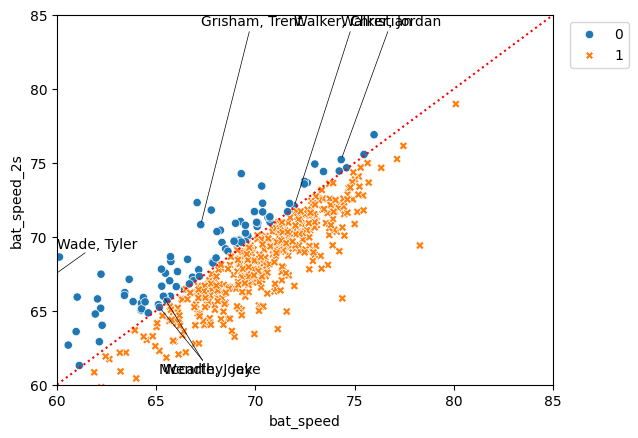

In [13]:
texts = [plt.text(row['bat_speed'],row['bat_speed_2s'],row['batter_name']) for idx, row in df_plt.loc[df_plt['coward']==0].sample(6).iterrows()]

ax = sns.scatterplot(data=df_plt, x='bat_speed', y='bat_speed_2s', style='coward', hue='coward')
plt.plot([60,85],[60,85],'r:')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
plt.xlim(60,85)
plt.ylim(60,85)
adjust_text(texts, only_move='y+', objects=ax.collections[0], arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
plt.show()

bat speed and squared up

https://twitter.com/matan_writes/status/1790477471197921458/photo/1  

In [14]:
_df_plt = df.loc[df['description']=='hit_into_play', ['batter','bat_speed']].groupby('batter',as_index=False).mean().rename(columns={'bat_speed':'bat_speed_avg'})
df = df.merge(_df_plt, how='left')
df['bat_speed_diff'] = df['bat_speed'].sub(df['bat_speed_avg'])

<IPython.core.display.Javascript object>

In [15]:
q = 0.23
df['max_ev'] = (df['bat_speed'].mul(1+q)).add(df['release_speed'].mul(0.92).mul(q))
df['max_ev%'] = df['launch_speed'].div(df['max_ev'])
df['squared_up'] = 0
df.loc[df['max_ev%']>=.8, 'squared_up'] = 1

<IPython.core.display.Javascript object>

In [16]:
df.loc[(df['batter']==650333) & (df['contact']==1), ['squared_up']].mean()

<IPython.core.display.Javascript object>

squared_up    0.486702
dtype: float64

In [17]:
df.loc[(df['batter']==650333) & (df['swing']==1), ['squared_up']].mean()

<IPython.core.display.Javascript object>

squared_up    0.439904
dtype: float64

<IPython.core.display.Javascript object>

<Axes: xlabel='bat_speed_diff', ylabel='Count'>

count    30954.00
mean         0.00
std          6.16
min        -68.06
25%         -2.23
50%          0.75
75%          3.31
max         22.04
Name: bat_speed_diff, dtype: float64

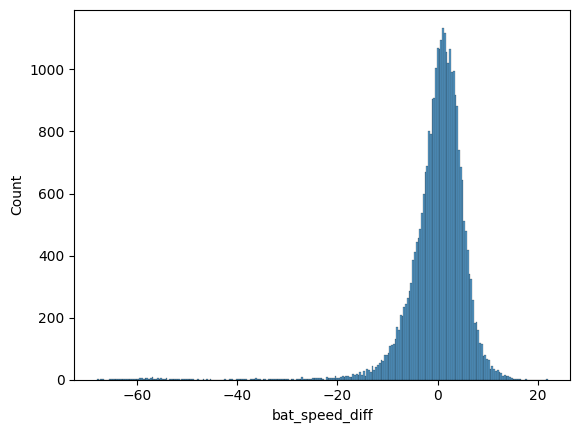

In [18]:
sns.histplot(df.loc[df['description']=='hit_into_play','bat_speed_diff'])
df.loc[df['description']=='hit_into_play','bat_speed_diff'].describe().round(2)

In [19]:
df['squared_up'].head()

<IPython.core.display.Javascript object>

0    1
1    1
2    0
3    0
4    0
Name: squared_up, dtype: int64

<IPython.core.display.Javascript object>

<Axes: xlabel='bat_speed_diff', ylabel='squared_up'>

(-16.0, 16.0)

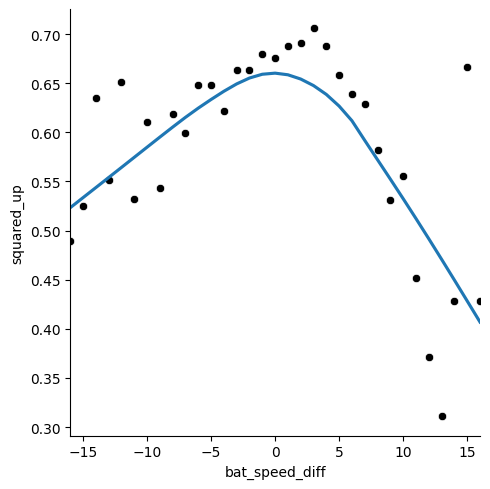

<Axes: xlabel='bat_speed_diff', ylabel='launch_speed'>

(-16.0, 16.0)

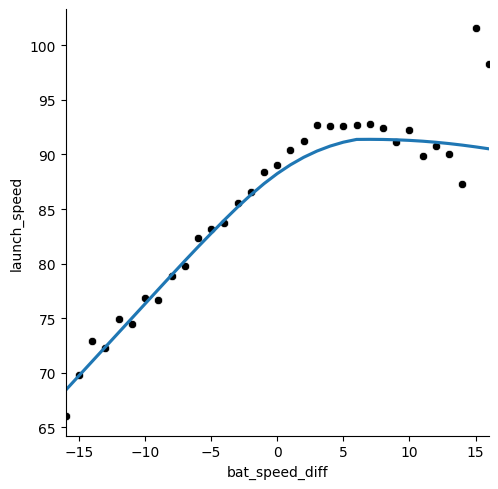

In [20]:
df['bat_speed_diff'] = df['bat_speed_diff'].round(0).astype(float)
df_plt = df.loc[(df['bat_speed_diff'].between(-16,16)) &(df['description']=='hit_into_play'), ['bat_speed_diff', 'squared_up','launch_speed']].dropna().groupby('bat_speed_diff', as_index=False).mean()

sns.lmplot(data=df_plt, x='bat_speed_diff', y='squared_up', lowess=True, scatter=False)
sns.scatterplot(data=df_plt, x='bat_speed_diff', y='squared_up', color='k')
plt.xlim(-16,16)
plt.show()

sns.lmplot(data=df_plt, x='bat_speed_diff', y='launch_speed', lowess=True, scatter=False)
sns.scatterplot(data=df_plt, x='bat_speed_diff', y='launch_speed', color='k')
plt.xlim(-16,16)
plt.show()

swing length and pitch loc
  
https://twitter.com/blandalytics/status/1790103287817187802  

In [21]:
def draw_sz(sz_top=3.5, sz_bot=1.5, ls='k-'):
  """
  draw strike zone
  draw the strike zone on a plot using mpl
  inputs:
    sz_top: top of strike zone (ft)
    sz_bot: bottom of strike zone (ft)
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    strike zone plot
  """
  plt.plot([-0.708, 0.708], [sz_bot,sz_bot], ls)
  plt.plot([-0.708, -0.708], [sz_bot,sz_top], ls)
  plt.plot([0.708, 0.708], [sz_bot,sz_top], ls)
  plt.plot([-0.708, 0.708], [sz_top,sz_top], ls)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: xlabel='plate_x_norm', ylabel='plate_z_norm'>

(0.0, 4.0)

(-2.0, 2.0)

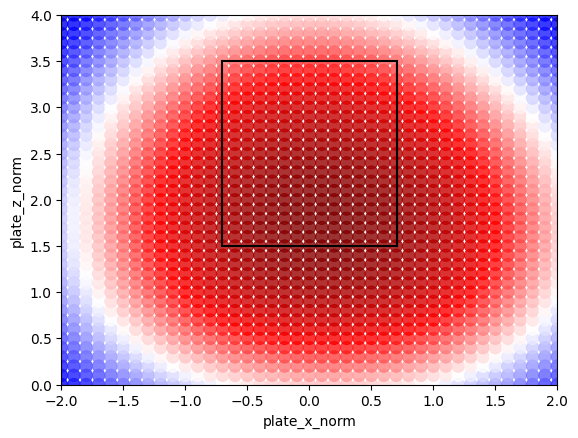

In [22]:
df['plate_x_norm'] = df['plate_x'].copy()
df.loc[df['stand']=='L', 'plate_x_norm'] = df.loc[df['stand']=='L', 'plate_x_norm'].mul(-1)
df['plate_x_norm'] = df['plate_x_norm'].round(1)
df['plate_z_norm'] = df['plate_z'].round(1)

x = 'plate_x_norm'
y = 'plate_z_norm'
hue = 'swing_length'

df_plt = df.loc[:, [x,y,hue]].groupby([x,y], as_index=False).mean()
_df = df_plt.copy()
_df = _df.groupby([x,y], as_index=False).sum()
_df = pd.pivot_table(data=_df, index=y, columns=x, values=hue, fill_value=0).astype(float)

df_gauss = pd.DataFrame(gaussian_filter(_df, sigma=10), index=_df.index, columns=_df.columns)
df_gauss = df_gauss.reset_index()
df_gauss = pd.melt(df_gauss, id_vars=y, value_name=hue)

sns.scatterplot(data=df_gauss, x=x, y=y, hue=hue, palette='seismic',
                edgecolor=None, s=80, markers='s',alpha=0.8, legend=False)

draw_sz()
plt.ylim(0,4)
plt.xlim(-2,2)
plt.show()

barrels

In [23]:
df.loc[:, ['launch_speed', 'launch_angle', 'launch_speed_angle']].sample(10)

<IPython.core.display.Javascript object>

,launch_speed,launch_angle,launch_speed_angle
28709,<NA>,<NA>,<NA>
136190,<NA>,<NA>,<NA>
186405,<NA>,<NA>,<NA>
196043,<NA>,<NA>,<NA>
174537,<NA>,<NA>,<NA>
237668,<NA>,<NA>,<NA>
36286,<NA>,<NA>,<NA>
117197,<NA>,<NA>,<NA>
117510,<NA>,<NA>,<NA>
150899,<NA>,<NA>,<NA>


In [24]:
df['launch_speed'] =df['launch_speed'].astype(float)
df['launch_angle'] =df['launch_angle'].astype(float)
df['launch_speed_angle'] =df['launch_speed_angle'].astype(float)

<IPython.core.display.Javascript object>

Launch speed/angle zone based on launch angle and exit velocity.  

1: Weak  
2: Topped  
3: Under  
4: Flare/Burner  
5: Solid Contact  
6: Barrel

<IPython.core.display.Javascript object>

<Axes: xlabel='bat_speed', ylabel='launch_speed'>

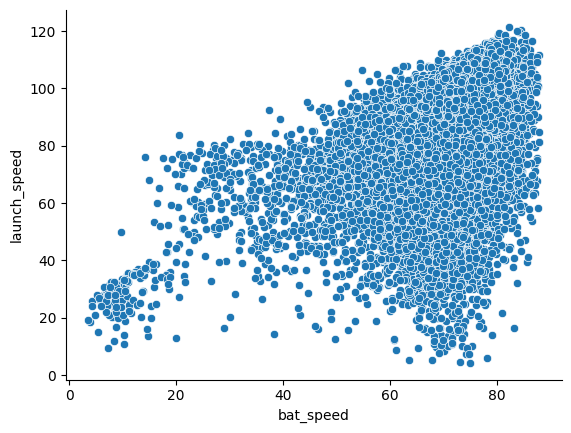

In [25]:
sns.scatterplot(data=df, x='bat_speed', y='launch_speed')
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

<Axes: xlabel='launch_speed', ylabel='launch_angle'>

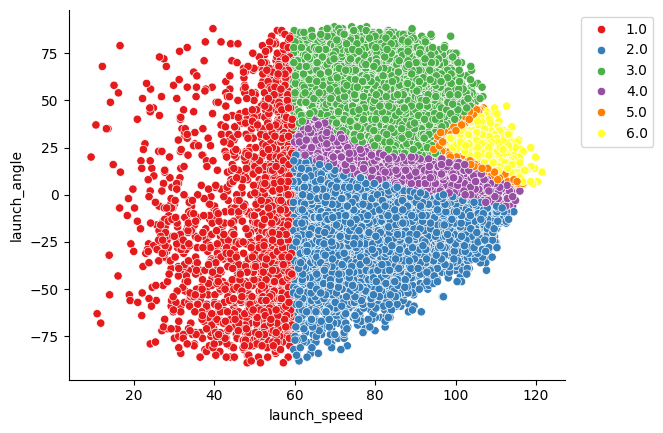

In [26]:
sns.scatterplot(data=df, x='launch_speed', y='launch_angle', hue='launch_speed_angle', palette='Set1')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

<Axes: xlabel='bat_speed', ylabel='launch_angle'>

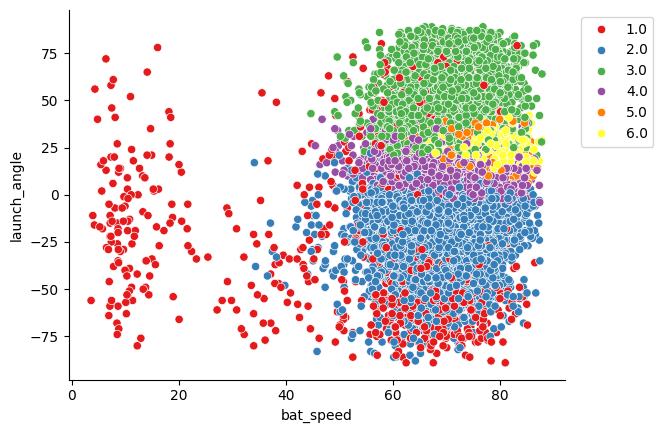

In [27]:
sns.scatterplot(data=df, x='bat_speed', y='launch_angle', hue='launch_speed_angle', palette='Set1')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()

In [28]:
import catboost as cb
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

In [29]:
df['barrel'] = 0
df.loc[df['launch_speed_angle']==6, 'barrel'] = 1

<IPython.core.display.Javascript object>

In [30]:
folds = 3
kf = KFold(folds, shuffle=True)
s = pd.Series()
feats = ['bat_speed', 'launch_angle']
target = 'barrel'

model_data = df.dropna(subset=feats+[target])
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(iterations=300, verbose=False)
  model.fit(train.loc[:, feats], train[target])
  _s = pd.DataFrame(model.predict_proba(test.loc[:, feats]), index=test.index)[1]
  s = pd.concat([s,_s])
model_data[f'{target}_cb'] = s

<IPython.core.display.Javascript object>

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
sns.scatterplot(data=model_data, x='bat_speed', y='launch_angle', hue=f'{target}_cb', palette='PRGn')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()